<a href="https://colab.research.google.com/github/FrancisKurian/CS530/blob/main/CS530_hw6_Decision_Tree_from_scratch_and_sklearn_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classification and Regression Trees (CART)
### CART models, also called decision trees are defined by recursively partitioning the input space, and defining a local model in each resulting region of input space. The overall model can be represented by a tree, with one leaf per region.

### The tree consists of a set of nested decision rules. At each node $i$, the feature dimension $di$ of the input vector $x$ is compared to a threshold value $ti$, and the input is then passed down to the left or right branch, depending on whether it is above or below threshold. 


# Gini Index and Selection of variable to split first (Gini Index as Cost Function or Impurity measure)
### Given a set of X features, first step is to understand where to begin the splits.This can be achieved using the cost function, Gini Index.The cost function of a decision tree seeks to find those cuts that minimize the error in classifyig the target value correclty.


<font size="5">Gini Index:  $$G_i = 1- \sum_{c}\hat{\pi}_{ic}^2$$ </font>

This is the expected error rate. To see this, note that $\hat{\pi}_{ic}^2$ is the probability a random entry in the leaf belongs to class c, and $1-\hat{\pi}_{ic}^2$ is the probability it would be misclassified.


Alternatively we can define cost as the entropy or deviance of the node:

<font size="5">Entropy:  $$H_i = -\sum_{c=1}^{C}\hat{\pi}_{ic}log\hat{\pi}_{ic}$$ </font>

Given one of the above cost functions, we can pick the best feature, and best threshold at each node. We then partition the data, and call the fitting algorithm recursively on each subset of the data

Let us take a look at how the index helps compare the features/cuts and that also reveals how the alogorithm works recursively.

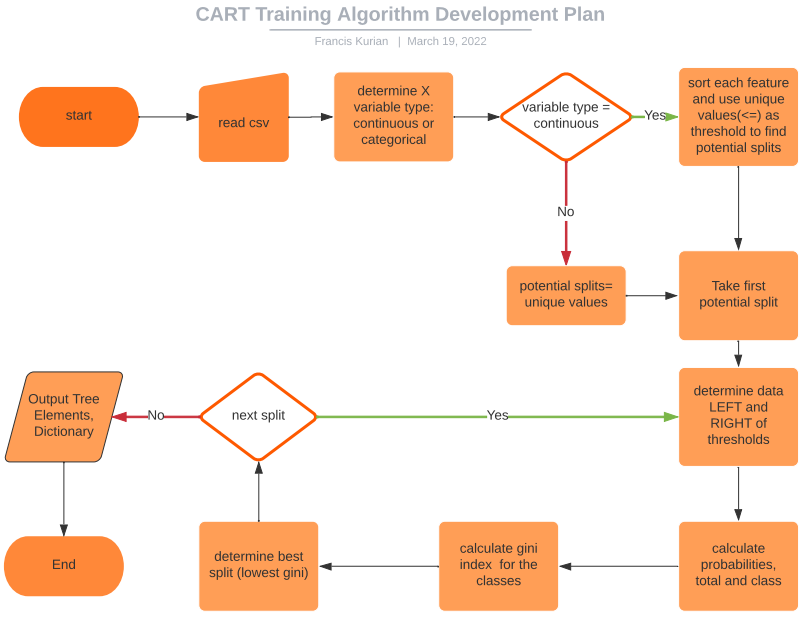

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving PlayTennis.csv to PlayTennis.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc,matthews_corrcoef
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler

import graphviz
import random
from pprint import pprint
%matplotlib inline
sns.set_style("darkgrid")

#Play Tennis Data Example

In [ ]:
df = pd.read_csv("PlayTennis.csv")
df = df.rename(columns={"play": "label"})
cols=df.columns
df_tennis=df.copy()
df.head()

,outlook,temp,humidity,windy,label
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes


In [ ]:
#unique values in each cols
def deduped_contents(data):
    deduped_contents2={}
    for col in range(len(cols) -1):
        col_contents = data[:,col]
        deduped_contents2[col]=np.unique(col_contents)
        #print('inside dedduped contents', col)
    return(deduped_contents2)

In [ ]:
def gini_local(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    probabilities = counts / counts.sum()
    # gini_l = sum(probabilities * -np.log2(probabilities))
    gini_l = 1-sum((probabilities**2))
    return gini_l

In [ ]:
def gini(left, right,key):
    tot=len(left) + len(right)
    p_left = len(left) / tot
    p_right = len(right) / tot
    gini_tot = p_left * gini_local(left) +  p_right * gini_local(right)
   
    return gini_tot    

In [ ]:
def gini_final(deduped_contents2,data):
    gini_out_final= 100

    for key, value in deduped_contents2.items():
        for i in range(len(value)):
            left = data[data[:,key] <= value[i]]
            right = data[data[:,key] > value[i]]
            #print('in gini final',key, value[i])     
            gini_out = gini(left,right,key)
            
            #print('inside gini final', key)

            if gini_out < gini_out_final:
                gini_out_final = gini_out
                col_id = key
                split_value=value[i]
         
    return(gini_out_final, col_id,split_value)
    

In [ ]:
#for categorical 

def gini_final(deduped_contents2,data):
    gini_out_final= 100

    for key, value in deduped_contents2.items():
        for i in range(len(value)):
            left = data[data[:,key] == value[i]]
            right = data[data[:,key] != value[i]]
           # print('in gini final',key, value[i])     
            gini_out = gini(left,right,key)
            
          #  print('inside gini final', key)

            if gini_out < gini_out_final:
                gini_out_final = gini_out
                col_id = key
                split_value=value[i]
         
    return(gini_out_final, col_id,split_value)
    

In [ ]:
sub_tree = {"question": ["true_ans", 
                         "false_ans"]}

In [ ]:
def check_single(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [ ]:
def grow_tree(df,var_type, min_sample=2,run_count=0, depth=5):
    if run_count==0:
        data = df.values
               
    else:
        data = df
        
    if check_single(data) or (len(data) < min_sample) or (run_count == depth) :
        out_val= list(np.unique(data[:,-1]))
        return out_val
    else:
        
        deduped_contents2 = deduped_contents(data)
        gini_val, col_id, split_value = gini_final(deduped_contents2,data)
        
        #print(cols[col_id])

        if var_type =='categorical':
            question = "{} = {}".format(cols[col_id], split_value)
            left_data=data[data[:,col_id] == split_value] 
            right_data = data[data[:,col_id] != split_value]
                              
        else:                     #if not categorical its continuous
            question = "{} <= {}".format(cols[col_id], split_value)
            left_data=data[data[:,col_id] <= split_value]  ### for continuous
            right_data = data[data[:,col_id] > split_value]
                              
        sub_tree = {question: []}
        
                
        true_ans=list(np.unique(left_data[:,-1])) #find unique labels in left data and store as list for true ans
        false_ans=list(np.unique(right_data[:,-1])) #find unique labels for false ans
        
        
        
        run_count +=1     
                
        true_ans= grow_tree(left_data,var_type,min_sample,run_count,depth)
        false_ans = grow_tree(right_data,var_type,min_sample,run_count,depth)
        
        
        if true_ans == false_ans:
            sub_tree=true_ans  
            #print(sub_tree)
        else:
            sub_tree[question].append(true_ans)
            sub_tree[question].append(false_ans)
        
        return sub_tree

In [ ]:
def predict_outcome(cases, tree,var_type):
    
    question_apply = list(tree.keys())[0]
    col_name, _ , value = question_apply.split(" ")
    
    if var_type=='categorical':
        if cases[col_name] == value:                  #chage for categorical 
                answer = tree[question_apply][0]
        else:
                answer = tree[question_apply][1]   
    else:                                         #if not categorical its continuous
        if cases[col_name] <= float(value):                  #chage for continuus
                answer = tree[question_apply][0]
        else:
                answer = tree[question_apply][1]  
    
    if not isinstance(answer, dict) :           #for those classifications which are not a dictionary
        return answer  
    else:
        tree_branch = answer
        return predict_outcome(cases, tree_branch,var_type)

In [ ]:
def accuracy(predictions, actual):
  return np.sum(predictions == actual)/len(actual)

In [ ]:
tree = grow_tree(df, min_sample=0, depth=5, var_type='categorical') # tennis
print ("\n")
pprint(tree)



{'outlook = overcast': [['yes'],
                        {'humidity = high': [{'outlook = rainy': [{'windy = False': [['yes'],
                                                                                     ['no']]},
                                                                  ['no']]},
                                             {'windy = False': [['yes'],
                                                                {'outlook = rainy': [['no'],
                                                                                     ['yes']]}]}]}]}


In [ ]:
df["predicted"] = df.apply(predict_outcome, axis=1, args=[tree],var_type='categorical')
df['predicted'] = df['predicted'].apply(lambda x: ','.join(x))

In [ ]:
mc_algo_tennis =matthews_corrcoef(df["label"],df["predicted"])
print(f'Matthews Coefficient for Algorithm from scratch is: {mc_algo_tennis:.5}')

Matthews Coefficient for Algorithm from scratch is: 0.6455


In [ ]:
df.to_csv('output_cart_tennis.csv')

# Iris  Data Set

In [ ]:
df = pd.read_csv("Iris.csv")
df = df.drop("Id", axis=1)
df = df.rename(columns={"Species": "label"})
cols=df.columns
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Split Training & Test

In [ ]:
df_train = df.sample(frac=0.70, replace=False)
df_test  = df.drop(df_train.index)
X_train = df_train.drop('label',axis=1)
y_train = df_train [['label']]
X_test = df_test.drop(['label'],axis=1)
y_test = df_test [['label']]

## Decision Tree for Iris Data

In [ ]:
tree = grow_tree(df_train, depth=5,var_type='continuous')
print ("\n")
pprint(tree)



{'PetalLengthCm <= 1.9': [['Iris-setosa'],
                          {'PetalWidthCm <= 1.7': [{'PetalLengthCm <= 5.0': [{'SepalLengthCm <= 4.9': [{'SepalWidthCm <= 2.4': [['Iris-versicolor'],
                                                                                                                                ['Iris-virginica']]},
                                                                                                       ['Iris-versicolor']]},
                                                                             ['Iris-virginica']]},
                                                   ['Iris-virginica']]}]}


In [ ]:
df_test["predicted"] = df_test.apply(predict_outcome, axis=1, args=[tree],var_type='continuous')
df_test['predicted'] = df_test['predicted'].apply(lambda x: ','.join(x))

In [ ]:
mc_algo_iris =matthews_corrcoef(df_test["label"],df_test["predicted"])
print(f'Matthews Coefficient for Algorithm from scratch is: {mc_algo_iris:.5}')

acc=accuracy(df_test['label'], df_test['predicted'])
print(f'Accuracy for Decision Tree from scratch is: {acc:.4}')


Matthews Coefficient for Algorithm from scratch is: 0.89978
Accuracy for Decision Tree from scratch is: 0.9333


## SK Learn Decision Tree Classifier

## Play Tennis Data
### Tennis dataset is small so we simply score it and check the prediction accuracy on Training Dataset only

In [ ]:
X = df_tennis.drop('label',axis=1)
y = df_tennis [['label']]
cat_columns = X.select_dtypes(['object']).columns
X[cat_columns] = X[cat_columns].apply(lambda x: pd.factorize(x)[0])

In [ ]:
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=4)   
clf_model.fit(X,y)
y_predict = clf_model.predict(X)
mc_sk_tennis=matthews_corrcoef(y.label, y_predict)
print(f'Matthews Coefficient for SKLearn DecisionTreeClassifier is: {mc_sk_tennis:.5}')

Matthews Coefficient for SKLearn DecisionTreeClassifier is: 1.0


#Iris Data

In [ ]:
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=5,max_leaf_nodes=5)   
clf_model.fit(X_train,y_train)
y_predict = clf_model.predict(X_test)

In [ ]:
mc_sk_iris=matthews_corrcoef(y_test.label, y_predict)
print(f'Matthews Coefficient for SKLearn DecisionTreeClassifier is: {mc_sk_iris:.5}')

Mattews Coefficient for SKLearn DecisionTreeClassifier is: 0.93611


# Decision Tree on Adult dataset from Week 5's homework

### Data prep and cleaning

In [ ]:
df_tr = pd.read_csv('adult.data',header=None)
df_te = pd.read_csv('adult.test',header=None)
col= ['age', 'workclass',  'fnlwgt',  'education',  'education_num',  'marital_status',  'occupation',  'relationship',  'race',  'sex',  'capital_gain',  'capital_loss',  'hours_per_week',  'native_country','Income'  ] 
df=pd.concat([df_tr, df_te], ignore_index=True)
df.columns= col
df['education']=df['education'].str.strip()
df['workclass']=df['workclass'].str.strip()
df['marital_status']=df['marital_status'].str.strip()
df['occupation']=df['occupation'].str.strip()
df['native_country']=df['native_country'].str.strip()

df.loc[df['education'].isin(['Preschool','1st-4th','5th-6th','7th-8th','9th']), 'education'] = 'Pre 10th'
df.loc[df['workclass'].isin(['Without-pay','Never-worked','?']), 'workclass'] = 'Unknown'
df.loc[df['marital_status'].isin(['Married-spouse-absent','Married-AF-spouse']), 'marital_status'] = 'Separated'
df.loc[df['occupation'].isin(['Priv-house-serv','Armed-Forces','?']), 'occupation'] = 'Miscellanious'
df.loc[df['native_country'] !='United-States', 'native_country'] = 'Non United-States'  
df["Income"].replace({' >50K' : 1,' >50K.' : 1, ' <=50K' : 0,' <=50K.' : 0,},inplace=True)
drop = ['education_num','fnlwgt' ] # removing did not reduce the overall prediction
df.drop(drop, axis=1, inplace=True)
min_max_scaler = MinMaxScaler()
df[["capital_gain", "capital_loss"]] = min_max_scaler.fit_transform(df[["capital_gain", "capital_loss"]])
df2=df.copy()

NameError: ignored

### Method1 :One hot encoding

In [ ]:
cat_colums=df.select_dtypes(include='object').columns
encoder=OneHotEncoder( sparse=False)
df_encoded = pd.DataFrame (encoder.fit_transform(df[cat_colums]))
df_encoded.columns = encoder.get_feature_names_out(cat_colums)
df.drop(cat_colums ,axis=1, inplace=True)
df_oh= pd.concat([df, df_encoded ], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_oh.drop(['Income'], axis=1), df_oh['Income'], test_size=0.333333, random_state=88)
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)

(32561, 56) (32561,) (16281, 56) (16281,)


### regularization in decision trees
* max_depth: Reducing  will regularize the model and thus reduce the risk of overfitting.
* min_samples_split : the minimum number of samples a node must have before it can be split.
* min_samples_leaf : the minimum number of samples a leaf node must have
* max_leaf_nodes : maximum number of leaf nodes

In [ ]:
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=15,min_samples_split=30,min_samples_leaf=4)   
clf_model.fit(X_train,y_train)
y_predict = clf_model.predict(X_test)
mc_sk_income=matthews_corrcoef(y_test, y_predict)
print(f'Matthews Coefficient for SKLearn DecisionTreeClassifier is: {mc_sk_income:.5}')
print(f'Accuracy of SKLearn DecisionTreeClassifier is: {clf_model.score(X_test, y_test):.5}')

Mattews Coefficient for SKLearn DecisionTreeClassifier is: 0.59314
Accuracy of SKLearn DecisionTreeClassifier is: 0.86143


### Method2 : Factorizing 

In [ ]:
cat_columns = df2.select_dtypes(['object']).columns
df2[cat_columns] = df2[cat_columns].apply(lambda x: pd.factorize(x)[0])
df2.head()
X2_train, X2_test, y2_train, y2_test = train_test_split(df2.drop(['Income'], axis=1), df2['Income'], test_size=0.333333, random_state=88)
print(X2_train.shape, y2_train.shape,X2_test.shape, y2_test.shape)

(32561, 12) (32561,) (16281, 12) (16281,)


In [ ]:
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=15,min_samples_split=30,min_samples_leaf=4)   
clf_model.fit(X2_train,y2_train)
y_predict = clf_model.predict(X2_test)
mc_sk_income=matthews_corrcoef(y2_test, y_predict)
print(f'Matthews Coefficient for SKLearn DecisionTreeClassifier is: {mc_sk_income:.5}')
print(f'Accuracy of SKLearn DecisionTreeClassifier is: {clf_model.score(X2_test, y2_test):.5}')

Mattews Coefficient for SKLearn DecisionTreeClassifier is: 0.58848
Accuracy of SKLearn DecisionTreeClassifier is: 0.85978


# Summary: Decision Tree from Scratch(CART) on 'Play Tennis' and 'Iris' data.  
### (Compared with SK Learn CART)

| Method | Dataset|Matthew's Coef| |            
| :- | --- | --- |:-:|
| Decison Tree (from Scratch)| Play Tennis | 0.6465 ||
| DecisionTreeClassifier |  Play Tennis |  1.00 |max depth|
| Decison Tree (from Scratch)| Iris | 0.8989 ||
| DecisionTreeClassifier | Iris | 0.9361 |tuned max depth|  

<br> </br>
# Summary: SK Learn CART with regularization on 'Adult Income' data.  
### (Compared with SK Learn Logistics regression with regularization)

| Method | Dataset|Accuracy| Matthew's Coef|            
| :- | --- | --- |:-:|
| SK Learn CART (One Hot)| Adult Income| 0.8614 |0.5931|
| SK Learn CART (Factorize) |  Adult Income|  0.8598 |0.5885|
| SK Learn Logistics| Adult Income | 0.8512 |0.5675|
| SK Learn Logistics(Lasso)| Adult Income | 0.8535 |0.5748|
| SK Learn Logistics(Ridge)| Adult Income | 0.8524 |0.5719|

### CART algorithm with one-hot encoding with max_depth and min_sample regularization performs better in terms of accuracy on test data. 

@ Jeomoan Francis Kurian